In [62]:
# Handle all imports

import os
import json
import collections
from collections import defaultdict, Counter
import math
import random

import pandas as pd
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit
import scipy
import scipy.stats
import nltk
import sklearn
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pylev

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
%matplotlib inline

## Read collected data

In [14]:
complete_data = []

with open("../data/complete_data.json") as f:
    for line in f:
        complete_data.append(json.loads(line))
        
unique_workers = set([ex['worker_id'] for ex in complete_data])

tot_ex_per_worker = defaultdict(int)
worker_examples = defaultdict(list)
worker_example_idxs = defaultdict(list)
few_ex_workers = set()
for worker_id in unique_workers:
    worker_examples[worker_id] = [ex for ex in complete_data if ex['worker_id']==worker_id]
    worker_example_idxs[worker_id] = [idx for idx, ex in enumerate(complete_data) if ex['worker_id']==worker_id]
    tot_ex_per_worker[worker_id] = len(worker_examples[worker_id])
    if tot_ex_per_worker[worker_id] < 5:
        few_ex_workers.add(worker_id)

unique_workers = unique_workers - few_ex_workers
    
# Read special keystrokes
with open("../data/special_keystrokes.txt") as f:
    special_keys = [line.strip() for line in f.readlines()]

## Compute heuristic features

In [21]:
# First we retrieve important statistics about all datapoints

times = [ex['timeSpentOnPage'] for ex in complete_data]
doc_lens = [len(ex['document'].split()) for ex in complete_data]
doc_lens_in_chars = [len(ex['document']) for ex in complete_data]
sents = [nltk.tokenize.sent_tokenize(ex['document']) for ex in complete_data]
ques_lens = [len(ex['question'].split()) for ex in complete_data]
quesop_lens = [len(ex["question"].split()) + len(ex["option1"].split()) + \
                len(ex["option2"].split()) + len(ex["option3"].split()) + \
                len(ex["option4"].split()) for ex in complete_data]

gold_labels = [ex['label'][-1] for ex in complete_data]  # Indices of the gold option
gold_ans = [ex['option' + label].lower() for ex, label in zip(complete_data, gold_labels)]  # Correct answers

# Edit keystrokes to exclude special keys
edited_keystrokes = []
for i in range(len(complete_data)):
    edited_keystrokes.append(complete_data[i]['keystrokes'])
    for skey in special_keys:
        if skey == "Shift" or skey == "ShiftLeft" or skey == "ShiftRight" or skey == "Enter" or skey == "Return" or \
        skey=="Tab":
            edited_keystrokes[i] = edited_keystrokes[i].replace(skey, "")
        else:
            edited_keystrokes[i] = edited_keystrokes[i].replace(skey, ">")
keystroke_lens = [len(edited_keystrokes[i].split()) for i in range(len(complete_data))]



# Compute average heuristic use for each worker and heuristic


# Serial-order

# Find examples where the correct answer exists as a span in the first / last sentence of the passage
serial_order_examples = [ex for i, ex in enumerate(complete_data) \
                         if gold_ans[i] in sents[i][0].lower() or gold_ans[i] in sents[i][-1].lower()]

serial_order_vals_by_worker = defaultdict(float)
for worker_id in unique_workers:
    worker_heuristic_examples = [ex for ex in serial_order_examples if ex['worker_id']==worker_id]
    serial_order_vals_by_worker[worker_id] = len(worker_heuristic_examples) / len(worker_examples[worker_id])
    

# Lowtime

log_time_vals_by_worker = defaultdict(float)
norm_time_vals_by_worker = defaultdict(float)
for worker_id in unique_workers:
    worker_times = [ex['timeSpentOnPage'] for ex in worker_examples[worker_id]]
    worker_norm_times = [ex["timeSpentOnPage"] / doc_lens[idx] for idx, ex in enumerate(complete_data) if idx in worker_example_idxs[worker_id]]
    worker_avg_time = sum(worker_times) / len(worker_times)
    worker_log_avg_time = np.log(worker_avg_time)
    log_time_vals_by_worker[worker_id] = worker_log_avg_time
    norm_time_vals_by_worker[worker_id] = np.log(sum(worker_norm_times) / len(worker_norm_times))

    
# Loweffort
            
avg_ques_lens_by_worker = defaultdict(float)
avg_keystroke_lens_by_worker = defaultdict(float)
avg_quesop_lens_by_worker = defaultdict(float)
avg_kq_by_worker = defaultdict(float)
for worker_id in unique_workers:
    worker_ques_lens = [ques_lens[idx] for idx in worker_example_idxs[worker_id]]
    worker_keystroke_lens = [keystroke_lens[idx] for idx in worker_example_idxs[worker_id]]
    worker_quesop_lens = [quesop_lens[idx] for idx in worker_example_idxs[worker_id]]
    avg_ques_lens_by_worker[worker_id] = sum(worker_ques_lens) / len(worker_ques_lens)
    avg_keystroke_lens_by_worker[worker_id] = sum(worker_keystroke_lens) / len(worker_keystroke_lens)
    avg_quesop_lens_by_worker[worker_id] = sum(worker_quesop_lens) / len(worker_quesop_lens)
    avg_kq_by_worker[worker_id] = avg_quesop_lens_by_worker[worker_id] / avg_keystroke_lens_by_worker[worker_id]


# Copying

def lcs_dp(x, y):
    x = [elem.lower() for elem in x]
    y = [elem.lower() for elem in y]
    dp_table = np.zeros((len(x)+1, len(y)+1))
    for i in range(1,len(x)+1):
        for j in range(1, len(y)+1):
            if x[i-1] == y[j-1]:
                dp_table[i-1, j-1] = 1 + dp_table[i-2, j-2]
            else:
                dp_table[i-1, j-1] = max(dp_table[i-1, j-2], 
                                dp_table[i-2, j-1])
    return dp_table[len(x)-1, len(y)-1]

copying_ques_vals = []
copying_quesop_vals = []
copying_max_vals = []
for ex in complete_data:
    lcss = []
    item_lens = []
    ques_lcs = lcs_dp(ex['document'].split(), ex['question'].split())
    copying_ques_vals.append(ques_lcs / len(ex['question'].split()))    
    lcss.append(ques_lcs)
    item_lens.append(len(ex['question'].split()))
    lcss.append(lcs_dp(ex['document'].split(), ex['option1'].split()))
    item_lens.append(len(ex['option1'].split()))
    lcss.append(lcs_dp(ex['document'].split(), ex['option2'].split()))
    item_lens.append(len(ex['option2'].split()))
    lcss.append(lcs_dp(ex['document'].split(), ex['option3'].split()))
    item_lens.append(len(ex['option3'].split()))
    lcss.append(lcs_dp(ex['document'].split(), ex['option4'].split()))
    item_lens.append(len(ex['option4'].split()))
    argmax_lcs = np.argmax(lcss)
    copying_max_vals.append(max(lcss) / item_lens[argmax_lcs])
    copying_quesop_vals.append(sum(lcss) / sum(item_lens))

avg_ques_copying_by_worker = defaultdict(float)
avg_quesops_copying_by_worker = defaultdict(float)
avg_max_copying_by_worker = defaultdict(float)
for worker_id in unique_workers:
    worker_ques_copying = [copying_ques_vals[idx] for idx in worker_example_idxs[worker_id]]
    worker_quesops_copying = [copying_quesop_vals[idx] for idx in worker_example_idxs[worker_id]]
    worker_max_copying = [copying_max_vals[idx] for idx in worker_example_idxs[worker_id]]
    avg_ques_copying_by_worker[worker_id] = sum(worker_ques_copying) / len(worker_ques_copying)
    avg_quesops_copying_by_worker[worker_id] = sum(worker_quesops_copying) / len(worker_quesops_copying)
    avg_max_copying_by_worker[worker_id] = sum(worker_max_copying) / len(worker_max_copying)
    
# First option bias
first_option_vals_by_worker = defaultdict(float)
for worker_id in unique_workers:
    worker_gold_labels = [gold_labels[idx] for idx in worker_example_idxs[worker_id]]
    first_option_vals_by_worker[worker_id] = worker_gold_labels.count("1") / tot_ex_per_worker[worker_id]


# Word Overlap
word_overlap_perc_by_worker = defaultdict(float)
for worker_id in unique_workers:
    worker_ques = [complete_data[i]["question"].lower().split() for i in worker_example_idxs[worker_id]]
    ques_pairwise_overlaps = []
    for i in range(len(worker_ques)):
        for j in range(len(worker_ques)):
            if i==j:
                continue
            ques_pairwise_overlaps.append(len(set(worker_ques[i]).intersection(set(worker_ques[j]))))
    word_overlap_perc_by_worker[worker_id] = sum(ques_pairwise_overlaps) / len(ques_pairwise_overlaps)


    

# Find the set of workers who rank in the top k% in heuristic use

PERC = 25

word_overlap_perc_by_worker_filt = {k: v for k, v in word_overlap_perc_by_worker.items() if k not in few_ex_workers}
sorted_word_overlap_perc_by_worker_filt = sorted(word_overlap_perc_by_worker_filt.values())
word_overlap_workers = [k for k, v in word_overlap_perc_by_worker_filt.items() if \
                       v < np.percentile(sorted_word_overlap_perc_by_worker_filt, PERC)]

serial_order_vals_by_worker_filt = {k: v for k, v in serial_order_vals_by_worker.items() if k not in few_ex_workers}
sorted_order = sorted(serial_order_vals_by_worker_filt.values())
serial_order_workers = [k for k,v in serial_order_vals_by_worker_filt.items() if \
                        v > np.percentile(sorted_order, 100-PERC)]

first_option_vals_by_worker_filt = {k:v for k, v in first_option_vals_by_worker.items() if k not in few_ex_workers}
sorted_order = sorted(first_option_vals_by_worker_filt.values())
first_option_workers = [k for k, v in first_option_vals_by_worker_filt.items() if \
                        v > np.percentile(sorted_order, 100-PERC)]

log_time_vals_by_worker_filt = {k:v for k, v in log_time_vals_by_worker.items() if k not in few_ex_workers}
sorted_order = sorted(log_time_vals_by_worker_filt.values())
lowtime_workers = [k for k, v in log_time_vals_by_worker_filt.items() if v < np.percentile(sorted_order, PERC)]

avg_ques_lens_by_worker_filt = {k:v for k, v in avg_ques_lens_by_worker.items() if k not in few_ex_workers}
sorted_order = sorted(avg_ques_lens_by_worker_filt.values())
loweffort_workers = [k for k, v in avg_ques_lens_by_worker_filt.items() if v < np.percentile(sorted_order, PERC)]

avg_ques_copying_by_worker_filt = {k:v for k, v in avg_ques_copying_by_worker.items() if k not in few_ex_workers}
sorted_order = sorted(avg_ques_copying_by_worker_filt.values())
copying_workers = [k for k,v in avg_ques_copying_by_worker_filt.items() if v > np.percentile(sorted_order, 100-PERC)]



## Compute low-dimensional PCA representation

In [71]:
X = np.zeros((len(word_overlap_perc_by_worker.keys()), 6))
counts = [0]*len(word_overlap_perc_by_worker.keys())
names = ["sat(time)","sat(effort)","serial_pos","copying","rep","avail"]
workers = []
pca_dict = {}
for i, worker_id in enumerate(word_overlap_perc_by_worker.keys()):
    X[i, 0] = log_time_vals_by_worker[worker_id]
    X[i, 1] = avg_ques_lens_by_worker[worker_id]
    X[i, 2] = -1*serial_order_vals_by_worker[worker_id]
    X[i, 3] = -1*avg_ques_copying_by_worker[worker_id]
    X[i, 4] = word_overlap_perc_by_worker[worker_id]
    X[i, 5] = -1*first_option_vals_by_worker[worker_id]
    workers.append(worker_id)
    
print(X.shape)

X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_embedded_pca = pca.fit_transform(X_std)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
p_axes = pca.components_.T
pca_dict = {workers[i]: v for i, v in enumerate(X_embedded_pca[:,0])}

(59, 6)


In [22]:
lowtime_quartile = [idx for idx in range(len(complete_data)) if complete_data[idx]["worker_id"] in lowtime_workers]
loweffort_quartile = [idx for idx in range(len(complete_data)) if complete_data[idx]["worker_id"] in loweffort_workers]
serial_order_quartile = [idx for idx in range(len(complete_data)) if complete_data[idx]["worker_id"] in serial_order_workers]
first_option_quartile = [idx for idx in range(len(complete_data)) if complete_data[idx]["worker_id"] in first_option_workers]
copying_quartile = [idx for idx in range(len(complete_data)) if complete_data[idx]["worker_id"] in copying_workers]
word_overlap_quartile = [idx for idx in range(len(complete_data)) if complete_data[idx]["worker_id"] in word_overlap_workers]



## Read question annotations to filter out invalid questions for analysis

In [55]:
context_labels = ["-Word_matching", "-Paraphrasing", "-Single_sentence", "-Multi_sentence", "-Coreferential"]
validity_labels = ["-Valid", "-Unsolvable", "-Ambiguous", "-Incorrect"]
reasoning_labels = ["-Math_numerical", "-Whole", "-Factuality", "-Spatial_Temporal", "-Negation", "-Explicit", "-Implicit"]

with open("../data/question_annotations.log") as f:
    question_annots = f.readlines()

validities = []
contexts = [[] for i in range(len(question_annots))]
reasonings = [[] for i in range(len(question_annots))]
invalids = []
for i, line in enumerate(question_annots):
    for valid_label in validity_labels:
        if valid_label in line:
            validities.append(valid_label[1:])
            break
    
    # Only include valid questions for further analysis
    if validities[-1]!="Valid":
        invalids.append(i)
        continue
        
    for context_label in context_labels:
        if context_label in line:
            contexts[i].append(context_label[1:])
    
    for reasoning_label in reasoning_labels:
        if reasoning_label in line:
            reasonings[i].append(reasoning_label[1:])

## Read predictions of bias-only models

In [89]:
ours = True

if ours:
    no_quest_cv = np.load("../data/predictions/control_partial_no_question_transf.npy")
    no_passage_cv = np.load("../data/predictions/control_partial_no_passage_transf.npy")
    overlap_cv = np.load("../data/predictions/control_overlap_transf.npy")
    fl_passage_cv = np.load("../data/predictions/control_fl_passage_transf.npy")
    valid_idxs = [i for i in range(len(complete_data)) if i not in invalids]
    include_idxs = []
    for idx, ex in enumerate(complete_data):
#         if idx in invalids:
#             continue
        include_idxs.append(idx)
    preds_no_quest = no_quest_cv[include_idxs]
    preds_no_passage = no_passage_cv[include_idxs]
    preds_fl_passage = fl_passage_cv[include_idxs]
    preds_overlap = overlap_cv[include_idxs].astype('float32')

    with open("../data/human_biased_annotations.txt") as f:
        human_data = json.load(f)

    human_tf = [int(gold_labels[i]==elem["worker_answer"][-1]) for i, elem in enumerate(human_data) if i not in invalids]

    with open("../data/crt_results.csv") as f:
        data = [line.strip().split(",") for line in f.readlines()]
        worker_crt3_accs = {data[0][i]: int(data[1][i]) for i in range(1, len(data[0]))} 
        worker_crt7_accs = {data[0][i]: int(data[2][i]) for i in range(1, len(data[0]))} 
        worker_vcrt_accs = {data[0][i]: int(data[3][i]) for i in range(1, len(data[0]))} 

    print("no_ques:", sum(preds_no_quest)/len(preds_no_quest))
    print("no_passage:", sum(preds_no_passage)/len(preds_no_passage))
    print("overlap:", sum(preds_overlap)/len(preds_overlap))
    print("fl_passage:", sum(preds_fl_passage)/len(preds_fl_passage))
    print("human_biased", sum(human_tf)/len(human_tf))
    
else:
    preds_no_quest = np.asarray(sources_nq)[idxs]
    preds_no_passage = np.asarray(sources_np)[idxs]
    preds_fl_passage = np.asarray(sources_npq)[idxs]

    print(sum(preds_no_quest)/len(preds_no_quest), sum(preds_no_passage)/len(preds_no_passage), 
          sum(preds_fl_passage)/len(preds_fl_passage))


no_ques: 0.5828571428571429
no_passage: 0.4138775510204082
overlap: 0.41959183673469386
fl_passage: 0.5469387755102041
human_biased 0.7978910369068541


## Compute CRT correlations

49
lowtime -- (1)
crt3: (0.3545010400387561, 0.012447453048260169)
crt7: (0.2737284300901098, 0.057019711691887194)
verbal-crt: (0.23549162752090796, 0.10333720202727413)
lowtime -- (2)
crt3: (0.34579432980513836, 0.014946613938549085)
crt7: (0.29062875188253756, 0.04278097349477763)
verbal-crt: (0.24846356607579484, 0.08516811567062776)
lowtime -- (3)
crt3: (0.3067925372920817, 0.032024031255568276)
crt7: (0.2428796493895962, 0.0926559474258363)
verbal-crt: (0.21246891539130192, 0.1427351500479039)
lowtime -- (4)
crt3: (0.30616538997698667, 0.03239487950416637)
crt7: (0.27277198060680674, 0.05792766443824869)
verbal-crt: (0.24709538257079203, 0.0869574614176807)
loweffort -- (1)
crt3: (0.298686799596226, 0.03709804485820619)
crt7: (0.3068748765658493, 0.031975604450175346)
verbal-crt: (0.364839529299986, 0.009952783686643703)
loweffort -- (2)
crt3: (0.28130892887150927, 0.05022188023039785)
crt7: (0.22227576246006328, 0.12477456132444026)
verbal-crt: (0.20551705348309113, 0.1565839612

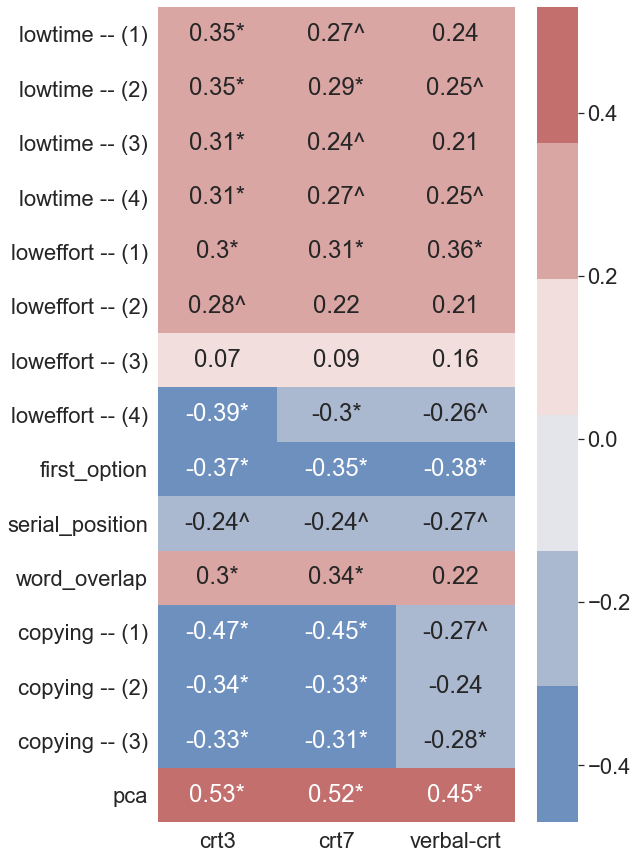

In [72]:
correl_list2_lists = [{k: math.exp(t) for k,t in log_time_vals_by_worker.items()}, log_time_vals_by_worker, 
                      {k: math.exp(t) for k,t in norm_time_vals_by_worker.items()}, norm_time_vals_by_worker,
                      avg_ques_lens_by_worker, avg_keystroke_lens_by_worker, avg_quesop_lens_by_worker, avg_kq_by_worker,
                      first_option_vals_by_worker,
                      serial_order_vals_by_worker,
                      word_overlap_perc_by_worker,
                      avg_ques_copying_by_worker, avg_quesops_copying_by_worker, avg_max_copying_by_worker,
                      pca_dict]
names = ["lowtime -- (1)", "lowtime -- (2)", "lowtime -- (3)", "lowtime -- (4)",
         "loweffort -- (1)", "loweffort -- (2)", "loweffort -- (3)", "loweffort -- (4)",
         "first_option",
         "serial_position",
         "word_overlap",
         "copying -- (1)", "copying -- (2)", "copying -- (3)",
         "pca"]

heatmap_matrix = np.zeros((len(correl_list2_lists), 3))
annot_matrix = [[] for _ in range(len(names))]

print(len(worker_crt7_accs))
for i, list2 in enumerate(correl_list2_lists):
    print(names[i])
    correl_list1 = []
    correl_list2 = []
    for worker_id in worker_crt7_accs.keys():
        if worker_id in list2:
            correl_list1.append(worker_crt7_accs[worker_id])
            correl_list2.append(list2[worker_id])
    
    crt3_correl = scipy.stats.pearsonr(correl_list1, correl_list2)
    print("crt3:", crt3_correl)
    heatmap_matrix[i][0] = round(crt3_correl[0], 2)
    annot_matrix[i].append(str(round(crt3_correl[0], 2)))
    
    if crt3_correl[1] <= 0.05:
        annot_matrix[i][0] += "*"
    elif crt3_correl[1] <= 0.1:
        annot_matrix[i][0] += "^"
    
    correl_list1 = []
    correl_list2 = []
    for worker_id in worker_crt3_accs.keys():
        if worker_id in list2:
            correl_list1.append(worker_crt3_accs[worker_id])
            correl_list2.append(list2[worker_id])
            
    crt7_correl = scipy.stats.pearsonr(correl_list1, correl_list2)
    print("crt7:", crt7_correl)
    heatmap_matrix[i][1] = round(crt7_correl[0], 2)
    annot_matrix[i].append(str(round(crt7_correl[0], 2)))
    
    if crt7_correl[1] <= 0.05:
        annot_matrix[i][1] += "*"
    elif crt7_correl[1] <= 0.1:
        annot_matrix[i][1] += "^"
    
    correl_list1 = []
    correl_list2 = []
    for worker_id in worker_vcrt_accs.keys():
        if worker_id in list2:
            correl_list1.append(worker_vcrt_accs[worker_id])
            correl_list2.append(list2[worker_id])
            
    vcrt_correl = scipy.stats.pearsonr(correl_list1, correl_list2)
    print("verbal-crt:", vcrt_correl)
    heatmap_matrix[i][2] = round(vcrt_correl[0], 2)
    annot_matrix[i].append(str(round(vcrt_correl[0], 2)))
    
    if vcrt_correl[1] <= 0.05:
        annot_matrix[i][2] += "*"
    elif vcrt_correl[1] <= 0.1:
        annot_matrix[i][2] += "^"
    
    
print(heatmap_matrix)
plt.figure(figsize=(8,15))
sns.set(font_scale=2)
sns.heatmap(heatmap_matrix, xticklabels=["crt3", "crt7", "verbal-crt"], yticklabels=names, annot=np.array(annot_matrix), fmt = '', cmap=sns.color_palette("vlag"))
# figure(figsize=(10, 10), dpi=80)
# plt.imshow(heatmap_matrix)
# plt.title("*CRT* Correlations")
# plt.yticks(np.arange(len(names)), names)
# plt.xticks(np.arange(3), ["crt3", "crt7", "verbal-crt"])

# Loop over data dimensions and create text annotations.
# for i in range(len(correl_list2_lists)):
#     for j in range(3):
#         text = plt.text(j, i, heatmap_matrix[i, j],
#                        ha="center", va="center", color="w")
# plt.colorbar()
# plt.savefig("crt_correls.pdf", bbox_inches='tight', dpi=1200)
plt.show()

## Compute correlations between per-annotator biased model accuracies and annotators heuristic values

<AxesSubplot:>

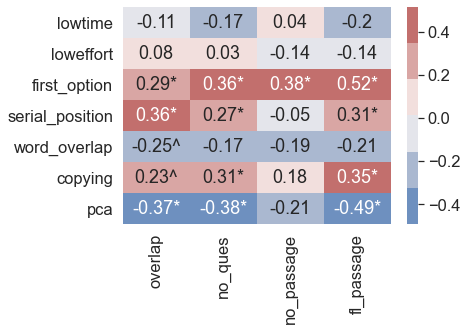

In [102]:
correl_lists = [log_time_vals_by_worker, avg_ques_lens_by_worker, 
                first_option_vals_by_worker, serial_order_vals_by_worker, 
                word_overlap_perc_by_worker, avg_ques_copying_by_worker, pca_dict]

names = ["lowtime", "loweffort", "first_option", "serial_position", "word_overlap", "copying", "pca"]

heatmap_matrix = np.zeros((len(correl_lists), 4))
annot_matrix = [[] for _ in range(len(correl_lists))]

for h, lis in enumerate(correl_lists):
    titles = ["overlap", "no_ques", "no_passage", "fl_passage"]
    for k, bias_preds in enumerate([preds_overlap, preds_no_quest, preds_no_passage, preds_fl_passage]):
        avg_feats = []
        avg_worker_bias_scores = []
        for worker_id in unique_workers:
            avg_feats.append(lis[worker_id])
            avg_worker_bias_score = [elem for i, elem in enumerate(bias_preds) if i in worker_example_idxs[worker_id]]
            avg_worker_bias_score = sum(avg_worker_bias_score) / len(avg_worker_bias_score)
            avg_worker_bias_scores.append(avg_worker_bias_score)

        axs[k].set_ylabel("Avg acc")
        axs[k].scatter(avg_feats, avg_worker_bias_scores, color="purple")
        axs[k].plot(avg_feats, b + m * np.array(avg_feats), '-')
        correl = scipy.stats.pearsonr(avg_worker_bias_scores, avg_feats)
        heatmap_matrix[h][k] = correl[0]
        
        title = titles[k] + " (" + str(round(correl[0], 2))
        annot_matrix[h].append(str(round(correl[0], 2)))
        if correl[1] < 0.05:
            title += "*"
            annot_matrix[h][k] += "*"
        elif correl[1] < 0.1:
            title += "^"
            annot_matrix[h][k] += "^"
            
        axs[k].set_title(title + ")")
    
sns.set(font_scale=1.5)
sns.heatmap(heatmap_matrix, xticklabels=titles, yticklabels=names, annot=np.array(annot_matrix), fmt = '', cmap=sns.color_palette("vlag")
)
